<a href="https://colab.research.google.com/github/ravirajgm/Raviraj_Data_Science_Case_Studies/blob/main/Logistic_Regression_Telco_churn_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Telecom case study to explore Logistic Regression and do churn analysis. The concept of Information Value [IV] and Weight of Evidence has been explored in detail. 
WoE = ln(%non-events/%events)
IV = Summation((%non-events - %events)*WoE)

In [ ]:
pip install sweetviz

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split    
from sklearn.metrics import accuracy_score,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import pandas_profiling as pp
import sweetviz as sv

In [10]:
#Load the Telco data for one month
telcodf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
telcodf.columns = [c[0].lower() + c[1:] for c in telcodf.columns]
telcodf['seniorCitizen'] = telcodf['seniorCitizen'].map({1:'Yes',0:'No'})
telcodf['label'] = telcodf['churn'].map({'Yes':1,'No':0})
telcodf['totalCharges'] = pd.to_numeric(telcodf['totalCharges'],errors='coerce')
telcodf.tail(5)


,customerID,gender,seniorCitizen,partner,dependents,tenure,phoneService,multipleLines,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTV,streamingMovies,contract,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,churn,label
7038,6840-RESVB,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0
7039,2234-XADUH,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0
7040,4801-JZAZL,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0
7041,8361-LTMKD,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,1
7042,3186-AJIEK,Male,No,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.50,No,0


In [62]:
telcodf.describe()

,tenure,monthlyCharges,totalCharges,label
count,7043.000000,7043.000000,7032.000000,7043.000000
mean,32.371149,64.761692,2283.300441,0.265370
std,24.559481,30.090047,2266.771362,0.441561
min,0.000000,18.250000,18.800000,0.000000
25%,9.000000,35.500000,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,0.000000
75%,55.000000,89.850000,3794.737500,1.000000
max,72.000000,118.750000,8684.800000,1.000000


In [7]:
sweetviz_report = sv.analyze([telcodf,'data'],target_feat='label')
sweetviz_report.show_html('viz.html')

                                             |          | [  0%]   00:00 -> (? left)

Report viz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Based on the EDA from sweetviz the following highlights are taken forward:
1. The ratio of male & female customers is almost the same with partner associated with almost everyone
2. The senior citizens are around 16% of the total data
3. Less than 30% of the customers have dependents
4. The average tenure of customer is 32 months
5. The Electronic paying customers are more than the other payment methods
6. The monthly charges average around $65
7. The month-to-month contract has the highest customer group - more than 60%
8. More than 25% of the customers have the churn labelled as 1

Function to calculate the Information Value

In [31]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [35]:
iv_woe(data=telcodf,target='label')

Information value of gender is 0.00038
Information value of seniorCitizen is 0.105621
Information value of partner is 0.118729
Information value of dependents is 0.155488
Information value of tenure is 0.823712
Information value of phoneService is 0.000745
Information value of multipleLines is 0.008207
Information value of internetService is 0.617953
Information value of onlineSecurity is 0.717777
Information value of onlineBackup is 0.528634
Information value of deviceProtection is 0.499725
Information value of techSupport is 0.699567
Information value of streamingTV is 0.380462
Information value of streamingMovies is 0.381374
Information value of contract is 1.23856
Information value of paperlessBilling is 0.203068
Information value of paymentMethod is 0.457109
Information value of monthlyCharges is 0.364717
Information value of totalCharges is 0.337553


(           Variable        IV
 0            gender  0.000380
 0     seniorCitizen  0.105621
 0           partner  0.118729
 0        dependents  0.155488
 0            tenure  0.823712
 0      phoneService  0.000745
 0     multipleLines  0.008207
 0   internetService  0.617953
 0    onlineSecurity  0.717777
 0      onlineBackup  0.528634
 0  deviceProtection  0.499725
 0       techSupport  0.699567
 0       streamingTV  0.380462
 0   streamingMovies  0.381374
 0          contract  1.238560
 0  paperlessBilling  0.203068
 0     paymentMethod  0.457109
 0    monthlyCharges  0.364717
 0      totalCharges  0.337553,
          Variable               Cutoff  ...       WoE        IV
 0          gender               Female  ...  0.019602  0.000191
 1          gender                 Male  ... -0.019409  0.000189
 0   seniorCitizen                   No  ... -0.156151  0.019669
 1   seniorCitizen                  Yes  ...  0.682371  0.085952
 0         partner                   No  ...  0.308156

In [11]:
#Identify categorcal & continuous variables
continuous, categorical = [], []
exclude = ['customerID','churn']

for col in [c for c in telcodf.columns if c not in exclude and c != 'label']:
    if is_numeric_dtype(telcodf[col]):
        continuous.append(col)
    else:
        categorical.append(col)


The IV is decided based on the following set rules:

IV < 0.02	predictive power useless for prediction

IV - 0.02 - 0.1	weak predictor

IV - 0.1 - 0.3	medium predictor

IV - 0.3 - 0.5	strong predictor

IV - > 0.5	suspicious or too good

Hence looking at the IV score, the following features can be considered for Logistic Regression of Churn:

seniorCitizen  0.105621

partner  0.118729

dependents  0.155488

paperlessBilling  0.203068

paymentMethod  0.457109

monthlyCharges  0.364717

totalCharges  0.337553

The ones with more than 0.5 are either too good to be true or needs deeper investigation


In [ ]:
#Create dummy variables for categorical variables:
dummy_srcitizen = pd.get_dummies(telcodf['seniorCitizen'])
dummy_partner  = pd.get_dummies(telcodf['partner'])
dummy_dependents = pd.get_dummies(telcodf['dependents'])
dummy_paperlessBilling  = pd.get_dummies(telcodf['paperlessBilling'])
dummy_paymentMethod = pd.get_dummies(telcodf['paymentMethod'])

In [31]:
telcodf_logist = pd.concat([dummy_srcitizen, dummy_partner, dummy_dependents, dummy_paperlessBilling,
                            dummy_paymentMethod, telcodf[['monthlyCharges', 'totalCharges', 'label']]], axis=1)
telcodf_logist.sample(10)

,No,Yes,No,Yes,No,Yes,No,Yes,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,monthlyCharges,totalCharges,label
2139,1,0,1,0,1,0,0,1,0,0,1,0,66.85,458.10,0
4148,1,0,1,0,1,0,1,0,0,1,0,0,19.35,601.60,0
3057,1,0,0,1,0,1,1,0,0,0,1,0,19.60,411.15,0
1962,1,0,1,0,1,0,0,1,0,1,0,0,99.95,2292.75,0
3494,1,0,0,1,0,1,0,1,1,0,0,0,85.35,754.65,1
2956,1,0,1,0,1,0,0,1,0,0,1,0,99.00,5038.15,0
3127,1,0,1,0,1,0,0,1,0,0,1,0,30.60,856.35,1
397,1,0,1,0,1,0,0,1,0,1,0,0,73.95,2524.45,1
5508,1,0,0,1,1,0,1,0,1,0,0,0,25.15,1940.85,0
3339,1,0,0,1,0,1,1,0,0,1,0,0,88.00,6161.90,0


In [32]:
telcodf_logist.isnull().sum()

No                            0
Yes                           0
No                            0
Yes                           0
No                            0
Yes                           0
No                            0
Yes                           0
Bank transfer (automatic)     0
Credit card (automatic)       0
Electronic check              0
Mailed check                  0
monthlyCharges                0
totalCharges                 11
label                         0
dtype: int64

In [41]:
#Fill null values of totalCharges with mean values
telcodf_logist['totalCharges'] = telcodf_logist['totalCharges'].fillna(telcodf['totalCharges'].mean())

In [43]:
telcodf_logist[telcodf_logist['totalCharges'].isnull()]

,No,Yes,No,Yes,No,Yes,No,Yes,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,monthlyCharges,totalCharges,label


Logistic Regression using Statsmodels

In [44]:
x_train,x_test,y_train,y_test = train_test_split(telcodf_logist.drop(['label'],axis=1),telcodf_logist['label'],train_size = 0.7,random_state=42)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [45]:
import statsmodels.api as sm
logistic_model = sm.Logit(y_train,sm.add_constant(x_train)).fit()
print (logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.452397
         Iterations 27
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 4930
Model:                          Logit   Df Residuals:                     4920
Method:                           MLE   Df Model:                            9
Date:                Tue, 15 Jun 2021   Pseudo R-squ.:                  0.2144
Time:                        17:05:05   Log-Likelihood:                -2230.3
converged:                       True   LL-Null:                       -2838.9
Covariance Type:            nonrobust   LLR p-value:                2.420e-256
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      -931.3798   2.42e+06     -0.000      1.000   -4.75

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


In [61]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train[['monthlyCharges','totalCharges']], y_train['label'])
reg.score(x_train[['monthlyCharges','totalCharges']], y_train['label'])
print(reg.coef_)
print(reg.intercept_)

[ 0.00800474 -0.00010735]
-0.010054638164334384


Identify churn minimum monthly charges

In [64]:
#Calculate the minimum monthly charges for which churn could happen
monthlychargesforchurn = (1+0.01)/(0.0342)
print(monthlychargesforchurn)

29.53216374269006


Confusion matrix for metrics analysis, ROC curve using sklearn library

In [49]:
# performing predictions on the test datdaset
yhat = logistic_model.predict(sm.add_constant(x_test))
prediction = list(map(round, yhat))
  
from sklearn.metrics import (confusion_matrix, accuracy_score)
  
# confusion matrix
cm = confusion_matrix(y_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[1411  128]
 [ 316  258]]
Test accuracy =  0.7898722195929957


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score

In [51]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1412  127]
 [ 316  258]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


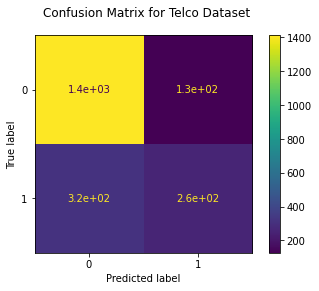

In [52]:
fig = plot_confusion_matrix(logreg, x_test, y_test, display_labels=logreg.classes_)
fig.figure_.suptitle("Confusion Matrix for Telco Dataset")
plt.show()

In [53]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('f1_score: {:.2f}'.format(f1_score(y_test, y_pred)))

Accuracy: 0.79
Error rate: 0.21
Precision: 0.67
Recall: 0.45
f1_score: 0.54


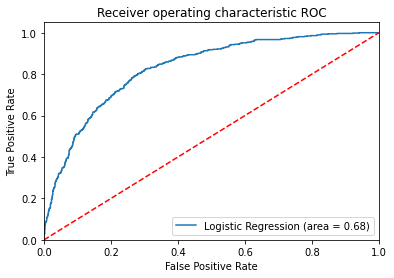

In [54]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")

plt.show()

In [55]:
y_pred_proba = logreg.predict_proba(x_test)[::,1]
roc_auc_score(y_test, y_pred_proba)

0.8293396091855655

Conclusion: The churner profile includes the following characteristics

1. Uses Electronic check for making payments
2. Uses monthly contracts
3. The minimum monthly charges for which churn could happen is above 30
